In [1]:
import os
import json
import pandas as pd
import numpy as np
import json

from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter, LogFormatterExponent, ScalarFormatter
import seaborn as sb

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

In [2]:
sb.set_style("darkgrid")
sb.set_context("paper",  font_scale = 1,
               rc={
                   "grid.linewidth": 3.75,
                   'axes.labelsize': 28,
                   "axes.titlesize": 32,
                   "legend.fontsize": 28.0,
                   'lines.linewidth': 5,
                   'xtick.labelsize': 24.0,
                   'ytick.labelsize': 24.0,
               })
current_palette = list(sb.color_palette())
colors = {
    'RL': current_palette[0],
    'RR': current_palette[5],
    'SOP':current_palette[4],
    'RAND':current_palette[7],
    'optimal':current_palette[1],
    '0':current_palette[-2],
    '1':current_palette[-1]
}

In [3]:
def plot(plot_bsf=True, old=False, lay=[5, 10, 20], uni=[20, 40], exp=[1, 2],
         expermient=['depot'], autolims=True):
    for epm in expermient:
        print(epm)
        for units in uni:
            for layers in lay:

                fig = plt.figure(figsize=(15, 5), dpi=50)
                ax = plt.gca()
                except_count = 0
                empty_count = 0
                for exploration in exp:
                    if not 'fold' in epm:
                        exp_dir = os.path.join(
                            os.path.sep, 'mhome', 'biedenka', 'rl-plan-tmp',
                            'experiments', epm,
                            '%s_full_train_set_%d-%d-%d' % (
                                epm, layers, units, exploration))
                    else:
                        exp_dir = os.path.join(
                            os.path.sep, 'mhome', 'biedenka', 'rl-plan-tmp',
                            'experiments', epm,
                            '%s_full_train_set_%d-%d-split-%d' % (
                                epm, layers, units, exploration))
                    if exploration == 1:
                        print('#'*80)
                        print(exp_dir)
                        print('#'*80)
                    try:
                        df = pd.read_csv(os.path.join(exp_dir, 'scores.txt'), sep='\t',
                                         index_col=None)
                        if df.empty:
                            continue
                    except Exception as e:
                        print(e)
                        continue

                    if not plot_bsf:
                        plt.step(df.steps, df['mean'] * -1, where='mid', label='mean',
                                 alpha=0.25)
                        plt.xlabel('#steps')
                    else:
                        mean = df['mean']
                        mead = df['median']
                        me, md = [], []
                        for idx, v in enumerate(zip(mean, mead)):
                            if idx == 0: 
                                me.append(v[0])
                                md.append(v[1])
                                continue
                            if v[0] > me[-1]:
                                me.append(mean[idx])
                                md.append(mead[idx])
                            else:
                                me.append(me[-1])
                                md.append(md[-1])
                        # additional +1 as reward is misaligned by 1
                        data = (np.array(me) +1) * -1
                        plt.step(df.steps, (np.array(me) +1) * -1, where='post',
                                label="{:s}-{:d}".format(
                                    'SEED' if 'fold' not in epm else 'SPLIT',
                                    exploration
                                ))
                        print('Final RL', data[-1])
                        #  plt.step(df.steps/1000, np.array(md) * -1, where='post',
                        #           label='median-bsf')

                ax.set_ylabel('RL-Cost')
                if plot_bsf:
                    ax.set_title('Individual Incumbent Performances on %s' % epm)
                    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
                              fancybox=True, shadow=True, ncol=4)
                    plt.xlabel('#steps')
                    if not autolims:
                        plt.ylim([0, 600])
                        plt.xlim([0, 1_000_000])
                else:
                    ax.set_title('Individual Performances on %s' % epm)
                    if not autolims:
                        plt.ylim([0, 1_500])
                        plt.xlim([0, 1_000_000])
                    plt.xlabel('#steps')
                ax.get_xaxis().set_major_formatter(
                FuncFormatter(lambda x, p: format(int(x), ',')))
#                 plt.savefig('toy_res_{:s}_layer_{:d}_units_{:d}_state_2.pdf'.format(
#                 'bsf' if plot_bsf else 'traj', layers, units), bbox_inches='tight')
#                 plt.savefig('toy_res_{:s}_layer_{:d}_units_{:d}_state_2.png'.format(
#                 'bsf' if plot_bsf else 'traj', layers, units), bbox_inches='tight')
                plt.show()
                print()
                print()

In [4]:
def plot_means(plot_bsf=True, old=False, lay=[5, 10, 20], uni=[20, 40], exp=[1, 2],
               quantile=False, expermient=['depot'], autolims=True):
    for epm in expermient:
        print(epm)
        for units in uni:
            for layers in lay:

                fig = plt.figure(figsize=(15, 5), dpi=50)
                ax = plt.gca()
                dfs = []
                except_count = 0
                empty_count = 0
                for exploration in exp:
                    if not 'fold' in epm:
                        exp_dir = os.path.join(
                            os.path.sep, 'mhome', 'biedenka', 'rl-plan-tmp',
                            'experiments', epm,
                            '%s_full_train_set_%d-%d-%d' % (
                                epm, layers, units, exploration))
                    else:
                        exp_dir = os.path.join(
                            os.path.sep, 'mhome', 'biedenka', 'rl-plan-tmp',
                            'experiments', epm,
                            '%s_full_train_set_%d-%d-split-%d' % (
                                epm, layers, units, exploration))
                    if exploration == 1:
                        print('#'*80)
                        print(exp_dir)
                        print('#'*80)
                    try:
                        df = pd.read_csv(os.path.join(exp_dir, 'scores.txt'), sep='\t',
                                         index_col=None)
                        if df.empty:
                            empty_count += 1
                        dfs.append(df)
                    except Exception as e:
                        except_count += 1
                        print(e)
                if except_count >= len(exp) or empty_count >= len(exp):
                    continue

                if not plot_bsf:
                    frame = pd.concat(dfs)
                    if quantile:
                        df = frame.groupby(frame.index).quantile(q=.5)
                        dsu = frame.groupby(frame.index).quantile(q=.75)
                        dsl = frame.groupby(frame.index).quantile(q=.25)
                        u = dsl['mean'] * -1
                        l = dsu['mean'] * -1
                        um = dsl['median'] * -1
                        lm = dsu['median'] * -1
                    else:
                        df = frame.groupby(frame.index).mean()
                        ds = frame.groupby(frame.index).std()
                        u = df['mean'] * -1 + ds['mean']
                        l = df['mean'] * -1 - ds['mean']
                        um = df['median'] * -1 + ds['median']
                        lm = df['median'] * -1 - ds['median']
                    plt.step(df.steps, df['mean'] * -1, where='post',
                             label='mean', color='blue')
                    plt.fill_between(df.steps, u, l, step='post', color='b', alpha=0.25)
    #                 plt.step(df.steps, df['median'] * -1, where='post',
    #                          label='median', color='orange')
    #                 plt.fill_between(df.steps, um, lm, step='post',
    #                                  color='orange', alpha=0.25)
                    plt.xlabel('#steps')
                else:
                    mes = []
                    stps = []
                    ml = -1
                    required_times = []
                    for df in dfs:
                        mean = df['mean']
                        mead = df['median']
                        steps = df['steps']
                        me, md = [], []
                        stp = []
                        for idx, v in enumerate(zip(mean, mead, steps)):
                            if idx == 0: 
                                me.append(v[0])
                                md.append(v[1])
                                stp.append(v[2])
                                continue
                            if v[0] > me[-1]:
                                me.append(mean[idx])
                                md.append(mead[idx])
                                stp.append(steps[idx])
                            else:
                                me.append(me[-1])
                                md.append(md[-1])
                                stp.append(steps[idx])
                        if len(me) > ml:
                            ml = len(me)
                        mes.append(me)
                        stps.append(stp)
                        try:
                            required_times.append(df['elapsed'].values[-1])
                        except:
                            required_times.append(np.nan)
                    required_times = np.nanmean(required_times)
#                     print(required_times, required_times/60,
#                           required_times/3600, required_times/(24*3600))
#                     days = int(required_times/(24*3600))%24
                    print('Average time taken: {:17.3f}[sec]'.format(required_times))
                    for idx in range(len(mes)):
                        while len(mes[idx]) < ml:
                            try:
                                mes[idx].append(mes[idx][-1])
                                stps[idx].append(stps[idx][-1])
                            except IndexError:
                                print(len(mes), len(mes[idx]))
                                mes[idx].append(np.nan)
                                stps[idx].append(np.nan)

                    if quantile:
                        m = -np.nanquantile(mes, q=.5, axis=0)
                        u = -np.nanquantile(mes, q=.25, axis=0)
                        l = -np.nanquantile(mes, q=.75, axis=0)
                    else:
                        m = -np.nanmean(mes, axis=0)
                        u = m + np.nanstd(mes, axis=0)
                        l = m - np.nanstd(mes, axis=0)
                    stps = np.nanmean(stps, axis=0)
                    plt.step(stps, m, where='post',
                             label='RL',
                             color=colors['RL'])

                    plt.fill_between(stps, u, l, step='post', alpha=0.25,
                             color=colors['RL'])
#                     print('Final RL', m[-1])
                    #  plt.step(df.steps/1000, np.array(md) * -1, where='post',
                    #           label='median-bsf')

                ax.set_ylabel('RL-Cost')
                if plot_bsf:
                    ax.set_title('Incumbent Performance on %s' % epm)
                    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
                              fancybox=True, shadow=True, ncol=4)
                    plt.xlabel('#steps')
                    
                    if not autolims:
                        plt.xlim([0, 1_000_000])
                        plt.ylim([0, 600])
    #                 plt.xlim([1, 1_000_000])
#                     plt.semilogx()
                else:
                    ax.set_title('Performance on %s' % epm)
                    if not autolims:
                        plt.ylim([0, 1_000])
                        plt.xlim([0, 1_000_000])
                    plt.xlabel('#steps')
                ax.get_xaxis().set_major_formatter(
                FuncFormatter(lambda x, p: format(int(x), ',')))
#                 plt.savefig(
#                     'toy_res_mean_over_10_runs_{:s}_layer_{:d}_'\
#                     'units_{:d}_state_2.pdf'.format(
#                 'bsf' if plot_bsf else 'traj', layers, units), bbox_inches='tight')
#                 plt.savefig(
#                     'toy_res_mean_over_10_runs_{:s}_layer_{:d}_'\
#                     'units_{:d}_state_2.png'.format(
#                 'bsf' if plot_bsf else 'traj', layers, units), bbox_inches='tight')
                plt.show()
                print()
                print()

<BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR>
# Results over 10 seeds

#### Plot Incumbent Performance

agricola
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/agricola/agricola_full_train_set_2-75-1
################################################################################
caldera
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/caldera/caldera_full_train_set_2-75-1
################################################################################
spider
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/spider/spider_full_train_set_2-75-1
################################################################################
snake
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/snake/snake_full_train_set_2-75-1
################################################################################
settlers
#####

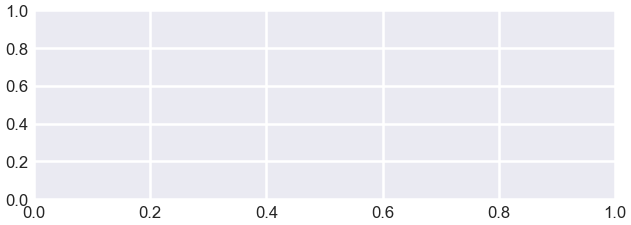

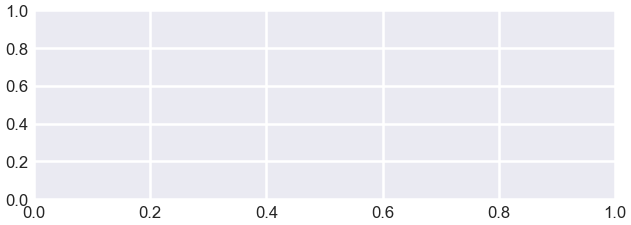

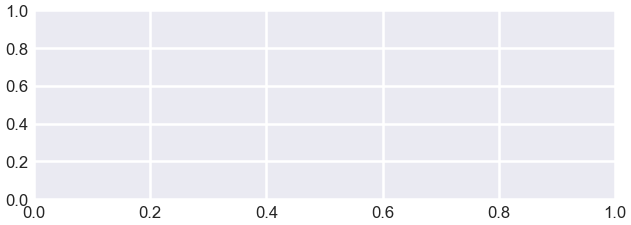

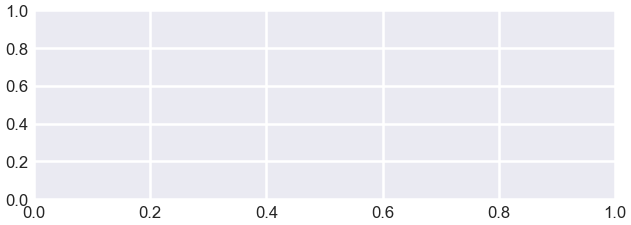

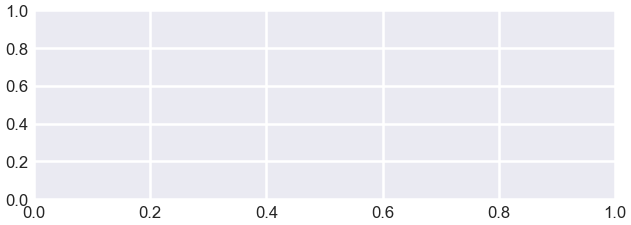

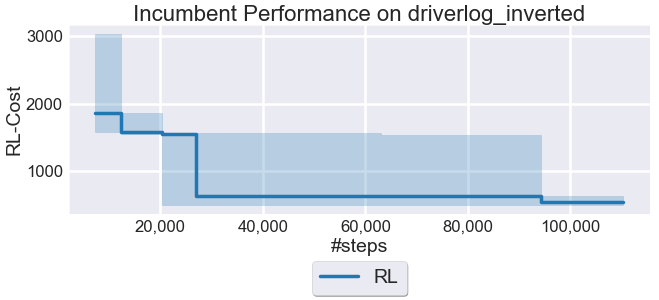



depot
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/depot/depot_full_train_set_2-75-1
################################################################################
Average time taken:        176347.307[sec]


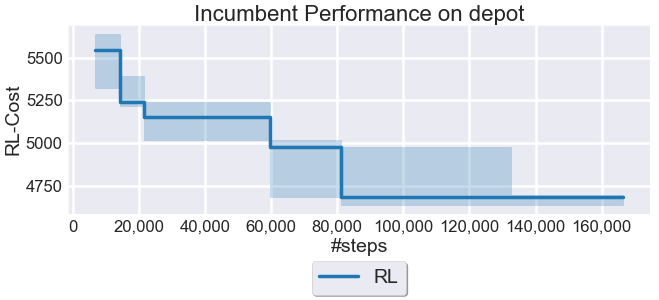



freecell
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/freecell/freecell_full_train_set_2-75-1
################################################################################
Average time taken:        109369.733[sec]


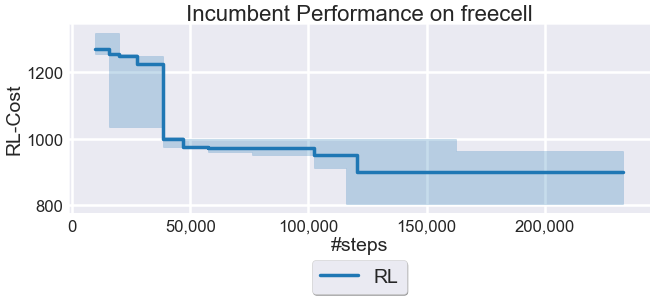



openstacks
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/openstacks/openstacks_full_train_set_2-75-1
################################################################################
Average time taken:        172732.434[sec]


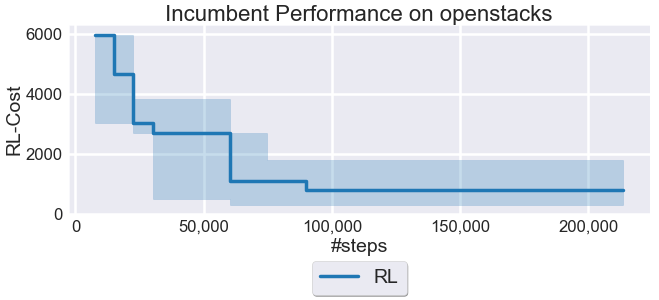



opticaltelegraphs
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/opticaltelegraphs/opticaltelegraphs_full_train_set_2-75-1
################################################################################
Average time taken:        145466.736[sec]


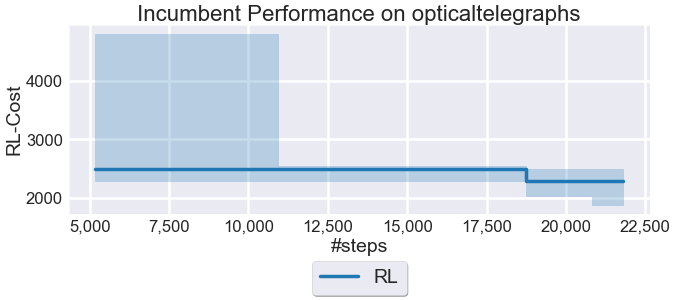



pipeswnt
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/pipeswnt/pipeswnt_full_train_set_2-75-1
################################################################################
Average time taken:        175125.408[sec]


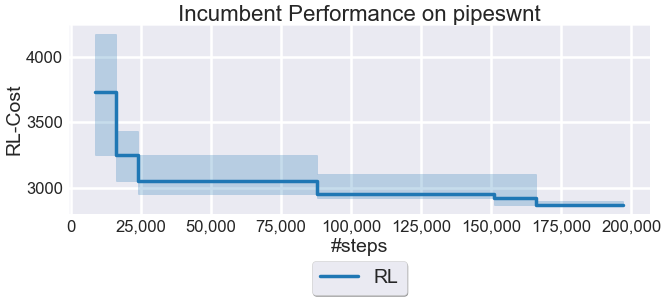



psrm
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/psrm/psrm_full_train_set_2-75-1
################################################################################
Average time taken:         70213.451[sec]


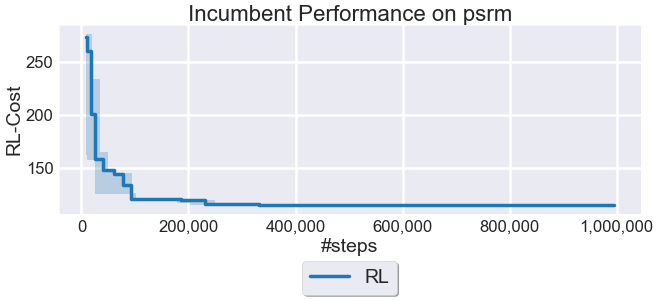



rovers
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/rovers/rovers_full_train_set_2-75-1
################################################################################
Average time taken:        167949.340[sec]


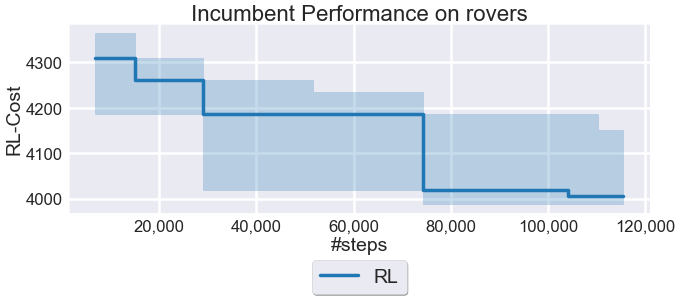



schedule
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/schedule/schedule_full_train_set_2-75-1
################################################################################
Average time taken:        171215.777[sec]


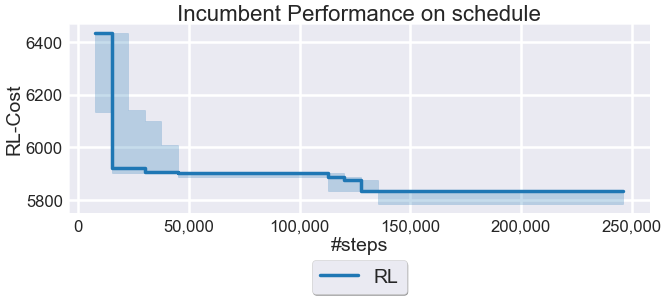



storage
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/storage/storage_full_train_set_2-75-1
################################################################################
Average time taken:        173055.192[sec]


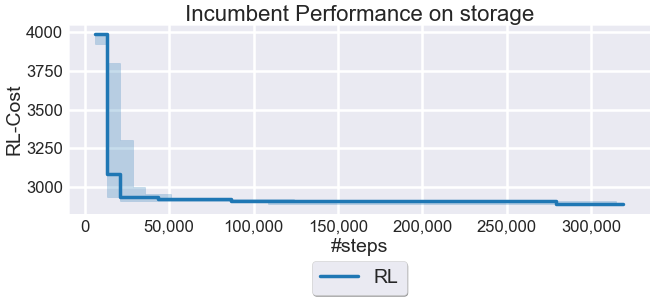



tpp
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/tpp/tpp_full_train_set_2-75-1
################################################################################
Average time taken:        173198.900[sec]


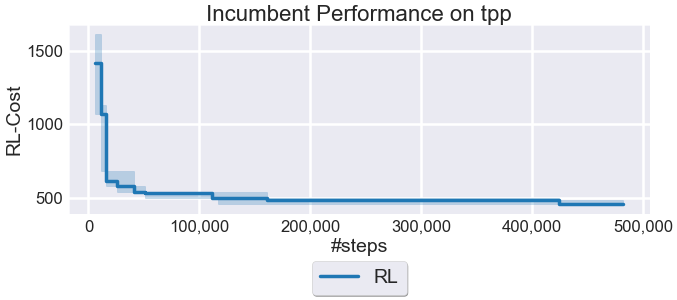

In [5]:
plot_means(plot_bsf=True, old=True, lay=[2], uni=[75],
           exp=[1, 2, 3, 4, 5], quantile=True, expermient=[
               'agricola',
               'caldera',
               'spider',
               'snake',
               'settlers',
               'driverlog_inverted',
#                '5-fold-grid',
               'depot',
               'freecell',
#                'logistics98',
#                'grid',
               'openstacks',
               'opticaltelegraphs',
               'pipeswnt',
#                'pipes',
#                'driverlog',
               'psrm',
               'rovers',
               'schedule',
               'storage',
               'tpp',
#                'trucks'
           ])

#### Plot RL Performance

##### Plots using mean +- stdev
plot_means(plot_bsf=False, old=True, lay=[2], uni=[75, 150, 200],
           exp=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], quantile=False)
           
           
           
##### Plots using Quartiles:           

##### Plots using Quartiles
plot_means(plot_bsf=False, old=True, lay=[2], uni=[75],
           exp=[1, 2, 3, 4, 5], quantile=True, expermient=[
               'depot',
               'freecell',
               'logistics98',
               'grid',
               'openstacks',
               'opticaltelegraphs',
               'pipeswnt',
               'pipes',
               'driverlog',
               'psrl',
               'psrm',
               'rovers',
               
               'schedule',
               'storage',
               'tpp',
               'trucks'
           ])

<BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR>
## Plotting individual runs
<BR>

No handles with labels found to put in legend.


agricola
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/agricola/agricola_full_train_set_2-75-1
################################################################################


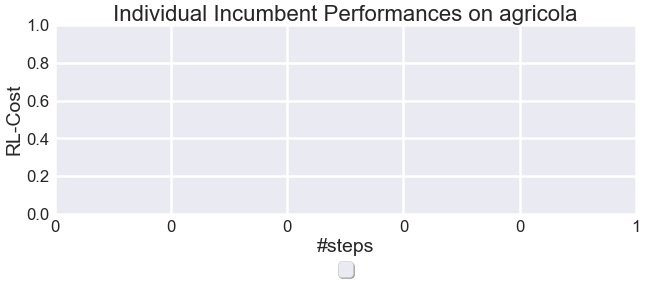

No handles with labels found to put in legend.




caldera
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/caldera/caldera_full_train_set_2-75-1
################################################################################


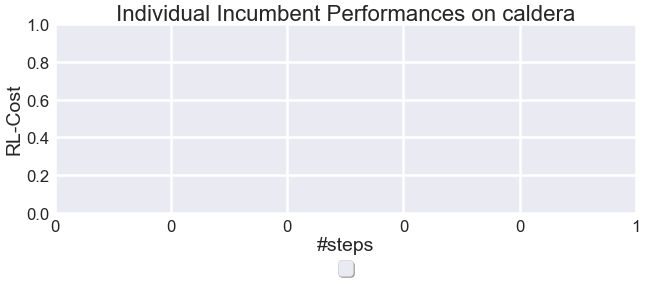

No handles with labels found to put in legend.




spider
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/spider/spider_full_train_set_2-75-1
################################################################################


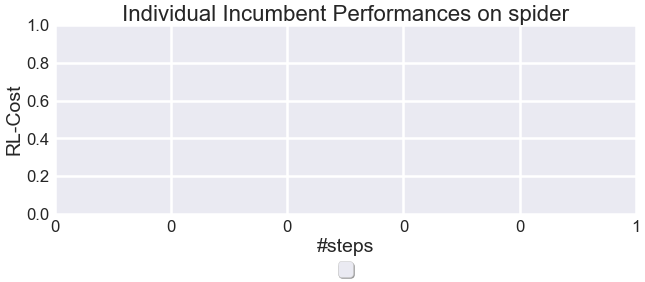

No handles with labels found to put in legend.




snake
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/snake/snake_full_train_set_2-75-1
################################################################################


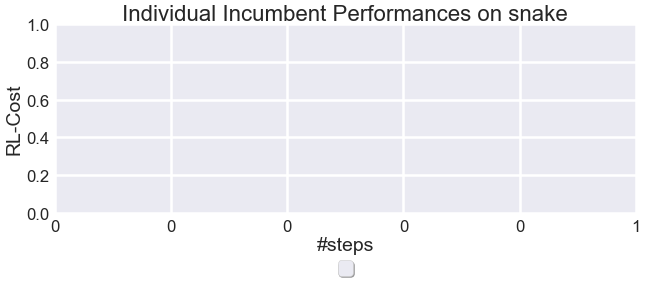

No handles with labels found to put in legend.




settlers
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/settlers/settlers_full_train_set_2-75-1
################################################################################


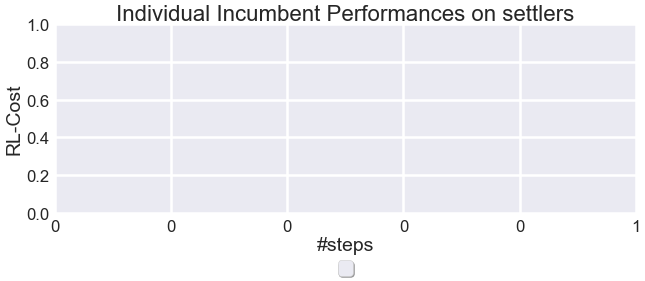



driverlog_inverted
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/driverlog_inverted/driverlog_inverted_full_train_set_2-75-1
################################################################################
Final RL 542.8
Final RL 1536.6
Final RL 417.6
Final RL 623.8
Final RL 491.4


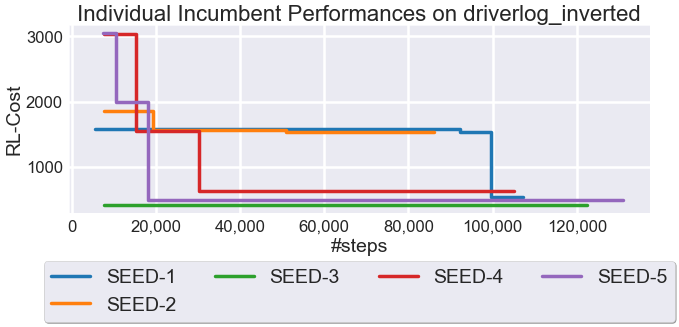



depot
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/depot/depot_full_train_set_2-75-1
################################################################################
Final RL 4636.3125
Final RL 4697.3125
Final RL 4685.5625
Final RL 4988.5625
Final RL 4486.1875


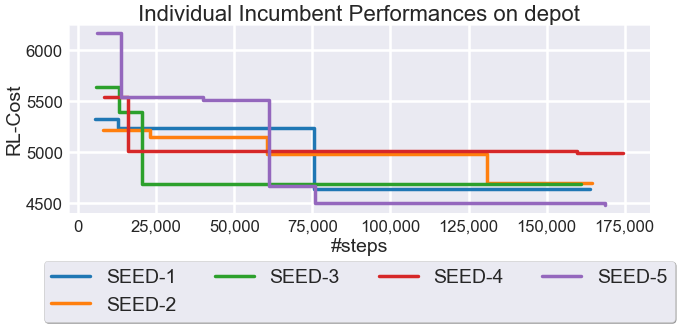



freecell
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/freecell/freecell_full_train_set_2-75-1
################################################################################
Final RL 774.9166666666665
Final RL 801.2
Final RL 899.9833333333332
Final RL 1003.9166666666665
Final RL 961.3166666666667


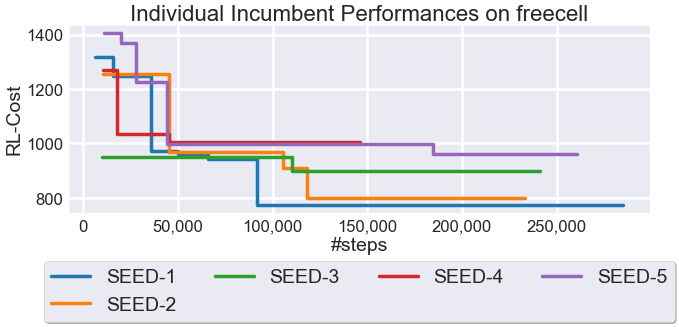



openstacks
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/openstacks/openstacks_full_train_set_2-75-1
################################################################################
Final RL 1797.0
Final RL 3832.391304347826
Final RL 286.17391304347825
Final RL 784.6086956521739
Final RL 174.34782608695653


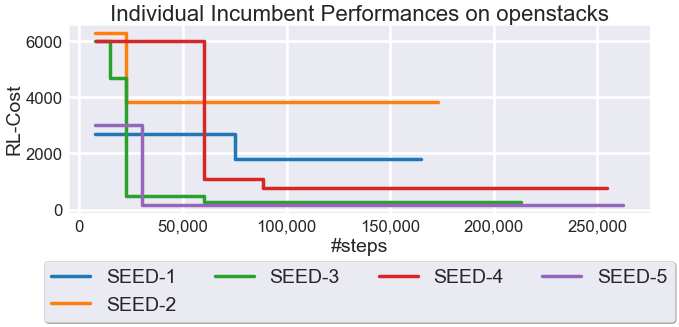



opticaltelegraphs
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/opticaltelegraphs/opticaltelegraphs_full_train_set_2-75-1
################################################################################
Final RL 1506.166666666667
Final RL 2566.333333333333
Final RL 2280.25
Final RL 1865.388888888889
Final RL 2494.1666666666665


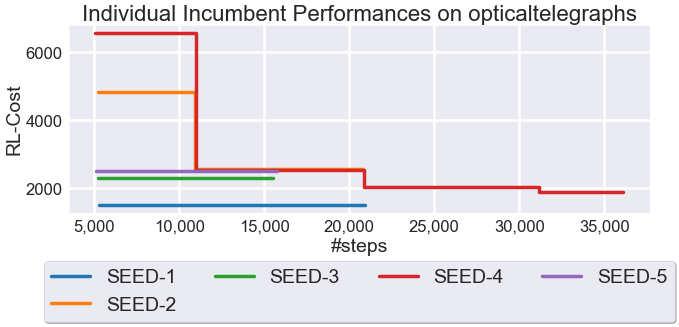



pipeswnt
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/pipeswnt/pipeswnt_full_train_set_2-75-1
################################################################################
Final RL 2864.972972972973
Final RL 2922.2432432432433
Final RL 2862.5945945945946
Final RL 2892.6756756756763
Final RL 2336.5945945945946


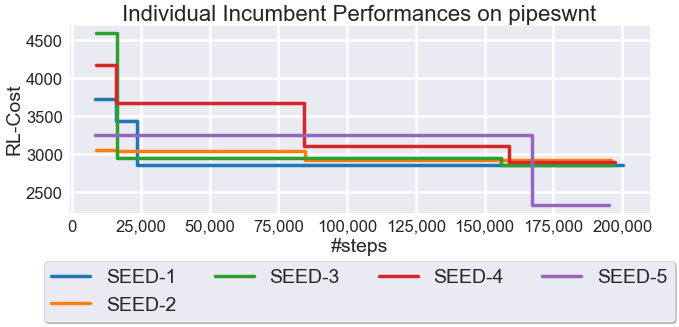



rovers
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/rovers/rovers_full_train_set_2-75-1
################################################################################
Final RL 4149.5
Final RL 3986.0333333333333
Final RL 3984.666666666666
Final RL 4234.5
Final RL 4003.766666666667


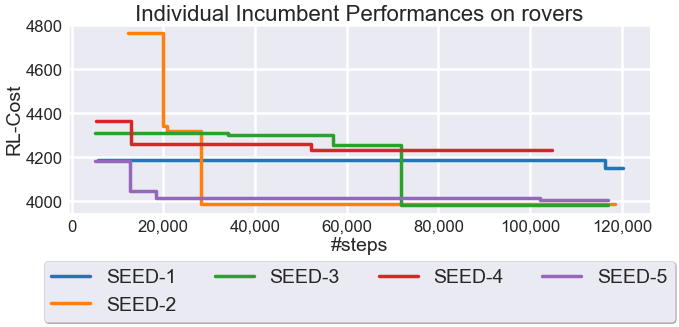



schedule
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/schedule/schedule_full_train_set_2-75-1
################################################################################
Final RL 5832.401785714284
Final RL 5833.973214285716
Final RL 5783.303571428572
Final RL 5876.973214285716
Final RL 5636.178571428572


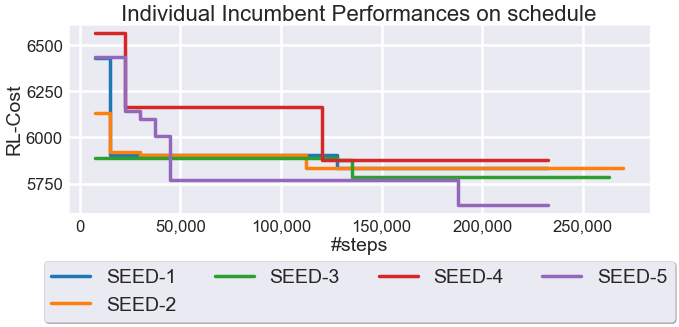



storage
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/storage/storage_full_train_set_2-75-1
################################################################################
Final RL 2903.7727272727275
Final RL 2877.0
Final RL 2869.2272727272725
Final RL 2883.7272727272725
Final RL 2889.0454545454545


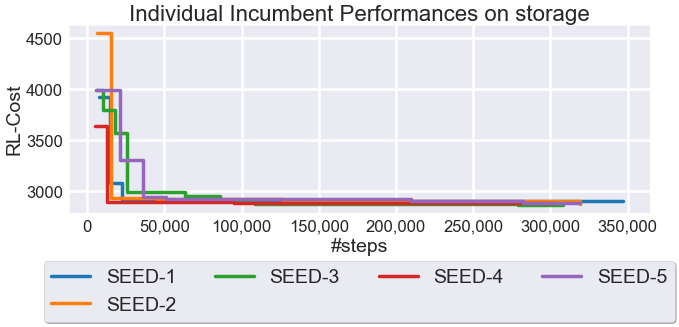



tpp
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/tpp/tpp_full_train_set_2-75-1
################################################################################
Final RL 481.8181818181818
Final RL 421.7272727272728
Final RL 446.7272727272728
Final RL 454.6818181818182
Final RL 539.4545454545455


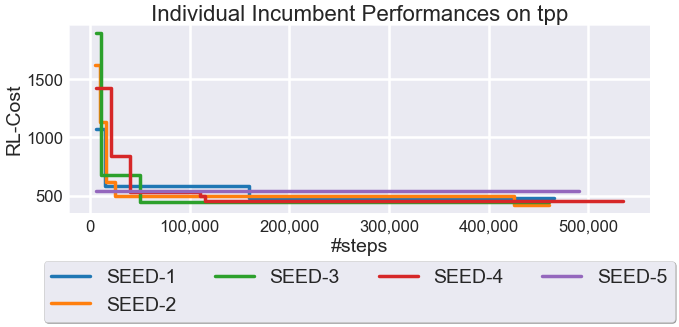

In [6]:
plot(old=True, lay=[2], uni=[75],
     exp=[1, 2, 3, 4, 5], expermient=[
       'agricola',
       'caldera',
       'spider',
       'snake',
       'settlers',
       'driverlog_inverted',
#        '5-fold-grid',
       'depot',
       'freecell',
#        'grid',
       'openstacks',
       'opticaltelegraphs',
       'pipeswnt',
#        'driverlog',
#        'psrm',
       'rovers',
       'schedule',
       'storage',
       'tpp',
#        'trucks'
     ])

plot(plot_bsf=False, lay=[2], uni=[75],
     exp=[1, 2, 3, 4, 5], expermient=[
         'depot',
         'freecell',
         'logistics98',
         'grid',
         'openstacks',
         'opticaltelegraphs',
         'pipeswnt',
         'pipes',
         'driverlog',
         'psrl',
         'psrm',
         'rovers',
         'satellite',
         'schedule',
         'storage',
         'tpp',
         'trucks'
     ])